## 이번 프로젝트의 흐름

1. 간단한 전처리만 수행한 데이터(결측치, categorical feature encoding)를 바로 Random Forest에 돌린 결과를 baseline으로 선정.
(Linear Regression은 사용하지 않았습니다. 왜냐면 categorical feature와 binary feature가 많은 경우에 동작하지 않을 것을 어느정도 예상했기 때문입니다)


2. 3가지 feature engineering 방법을 사용합니다.
- 우선 categorical feature는 모두 one-hot encoding을 합니다.


> 2-1. Correlation check (threshold는 0.9로 세팅)

> 2-2. feature importance가 0.1을 넘는 feature만 선택

> 2-3. PCA로 90%를 보존하는 차원으로 차원감소



3. 해당 모델마다 동일한 범위 내에서 optuna로 hyper-parameter tuning을 수행하여 성능을 비교합니다. 비교하여 성능이 높은 feature engineering 기법을 고릅니다.

> train-validation split은 9:1로 합니다.


4. LightGBM으로 모델을 변경 후, optuna로 hyper-parameter tuning을 열심히 돌립니다.


5. 최종 모델 선정

## 1. 라이브러리, 데이터 불러오기

In [ ]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMRegressor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [ ]:
# flag setting
feature_reducing = "feature_importance" # "correlation" / "feature_importance" / "PCA"

In [5]:
# 데이터를 불러옵니다.
base_path = "./mercedes-benz-greener-manufacturing/"
train = pd.read_csv(base_path + "train.csv")
test = pd.read_csv(base_path + "test.csv")

## 2. EDA

#### 찾은 특징들


1. 결측치 : 없음


2. dtype이 object인 column : X0 ~ X8까지 8개. (categorical feature)

> -> 어떻게 처리할지 고민해야함. (Ordinal Encoding VS One-Hot Encoding)

> -> categorical feature들은 종류 정보들이 알파벳으로 되어있으며(anomynized) 이 정보들 대비 target값의 차이가 있는지 확인.
(특별하게 관련 없음)

> -> binary feature들중에서 0만 가지고 있는 column들이 있음.

> -> 정보가 충분하지 않다고 판단(target value와의 관련성 0) 삭제.


3. target distribution
-> train data에 180을 넘는 데이터가 하나 있음. 이 데이터를 outlier라고 생각하고 제거.

### 3. 전처리

#### 결측치 처리

In [6]:
# 결측치가 있는 column
train[train.isnull().any(axis=1)]

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385


In [7]:
test[test.isnull().any(axis=1)]

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385


#### feature 구분

- X0 ~ X8 : categorical feature

- other features : binary feature(0 / 1)

In [8]:
categorical_features = train.columns[2:10]
categorical_features

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], dtype='object')

In [9]:
temp = train.columns[10:]
temp

Index(['X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       ...
       'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384',
       'X385'],
      dtype='object', length=368)

In [10]:
card1 = train.columns[train.nunique() == 1]
card1

Index(['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293',
       'X297', 'X330', 'X347'],
      dtype='object')

In [11]:
binary_features = np.setdiff1d(temp, card1)
print("%d features - %d features = %d binary features" % (len(temp), len(card1), len(binary_features)))

368 features - 12 features = 356 binary features


### feature engineering

1. Correlation


2. feature importance


3. PCA

In [12]:
# feature engineering을 위해 tempX, y 생성
total = pd.concat([train, test])
split_point = len(train)
total_OHE = pd.get_dummies(data=total, columns=categorical_features)
y = train.y
tempX = total_OHE.drop(columns=["ID", "y"])
tempX = tempX.drop(columns=card1)
trainX = tempX[:split_point]
testX = tempX[split_point:]
print(trainX.shape, testX.shape, y.shape)

(4209, 567) (4209, 567) (4209,)


In [13]:
trainX # sponge

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4206,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4207,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [14]:
testX

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4205,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4206,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4207,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [15]:
# 1. correlation

# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
def remove_collinearity(X, threshold):
    """
    X : feature matrix
    threshold : 다중공선성을 제거할 column을 고르는 기준 값. [0, 1]
    """
    
    corr = X.corr()
    candidate_cols = []
    
    for x in corr.iterrows():
        idx, row = x[0], x[1] # decoupling tuple
        # 해당 row는 이미 처리가 되어서 볼 필요가 없다.
        if idx in candidate_cols:
            continue
        #print(row[row > 0.7].index[1:])
        candidates = row[row > threshold].index[1:]

        # 자기 자신을 제외하고 threshold를 넘는 column이 있다면,
        if len(candidates) != 0:
            for col in candidates:
                candidate_cols.append(col)           
    
    return candidate_cols

def find_feature_importance(X, model, show_plot):

    feat_names = X.columns.values
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(12,12))
    plt.title("Feature importances")
    plt.bar(range(len(indices)), importances[indices], color="r", align="center")
    plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
    plt.xlim([-1, len(indices)])
    plt.show()
    
    important_features = X.columns[importances >= 0.005]
    return important_features
    
def apply_PCA(X, show_plot):
    from sklearn.decomposition import PCA
    # training data와 test data를 모두 PCA를 이용하여 차원 감소를 수행합니다.
    pca = PCA(n_components=0.90) # 원래 데이터의 90%를 보존하는 차원.
    pca_090 = pca.fit(X) # 학습 및 변환
    reduced_X = pca_090.transform(X)
    print(reduced_X.shape)
    
    if show_plot:
        labels = [f"PC{x}" for x in range(1, reduced_X.shape[1]+1)]
        pca_090_variance = np.round(pca_090.explained_variance_ratio_.cumsum()*100, decimals=1)
        plt.figure(figsize=(25,5))
        plt.bar(x=range(1, len(pca_090_variance)+1), height=pca_090_variance, tick_label=labels)

        plt.xticks(rotation=90, color='indigo', size=15)
        plt.yticks(rotation=0, color='indigo', size=15)
        plt.title('Scree Plot',color='tab:orange', fontsize=25)
        plt.xlabel('Principal Components', {'color': 'tab:orange', 'fontsize':15})
        plt.ylabel('Cumulative percentage of explained variance ', {'color': 'tab:orange', 'fontsize':15})
        plt.show()
        
        X_train_pca_df = pd.DataFrame(reduced_X, columns=labels)
        display(X_train_pca_df)

    return pca_090, X_train_pca_df

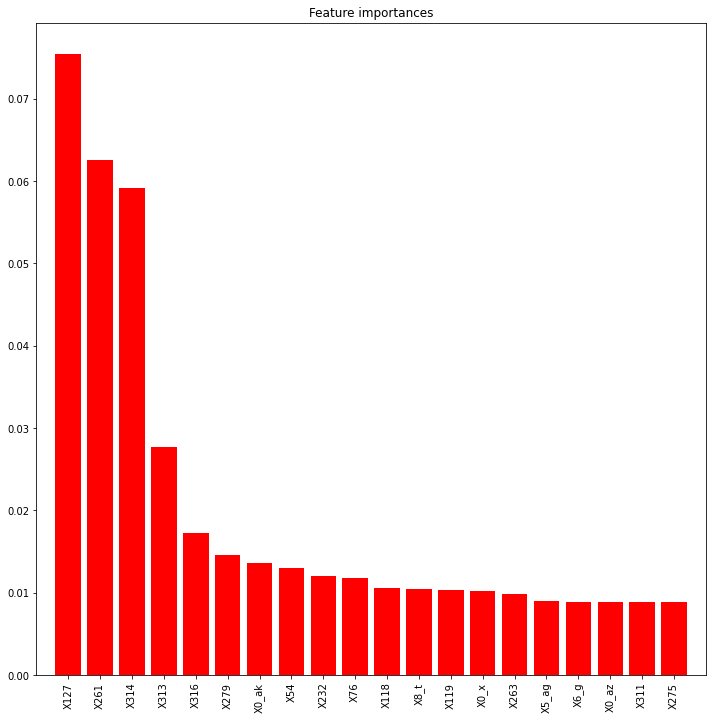

(4209, 37)


In [16]:
# PCA 적용
if feature_reducing == "correlation":
    threshold = 0.7
    correlated_features = remove_collinearity(trainX, threshold)
    correlated_features = set(correlated_features) # 중복 제거
    print("%d Correlation features over %.2f" % (len(correlated_features), threshold))
    
    X = trainX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    show_plot = True
    model = RandomForestRegressor(max_features="sqrt", n_jobs=-1, random_state=0xC0FFEE)
    model.fit(trainX, y)
    important_features = find_feature_importance(trainX, model, show_plot)
    X = trainX[important_features]
    print(X.shape)
    
elif feature_reducing == "PCA":
    show_plot = True
    pca_model, X = apply_PCA(trainX, show_plot)
    print(X.shape)

### 4. 학습 데이터 분할

In [17]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0xC0FFEE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3788, 37) (421, 37) (3788,) (421,)


### 5. 학습 및 평가 (debugging 용도)

In [18]:
print("\nFitting Random Forest...")
model = RandomForestRegressor(max_features='sqrt', n_jobs=-1)
model.fit(X_train, y_train)


Fitting Random Forest...


RandomForestRegressor(max_features='sqrt', n_jobs=-1)

In [19]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
from sklearn.metrics import r2_score
evaluation_metric = r2_score

In [20]:
print("Prediction")
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)


train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

Prediction
Train Score : 0.7337
Test Score : 0.4359


### 6. Hyper-parameter Tuning

- optuna를 갈아넣습니다!

In [21]:
# For Regression

def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 8, 30)
    max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt', 'log2'])
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  n_jobs=-1,
                                  random_state=0xC0FFEE)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    scores = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = evaluation_metric(y_val, preds)
        scores.append(score)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(scores)

In [22]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

rf_study = optuna.create_study(study_name="RF", direction="maximize") # regression task에서 R^2를 최대화!
rf_study.optimize(opt_func, n_trials=30)

[I 2022-06-05 07:28:42,090] A new study created in memory with name: RF
[I 2022-06-05 07:28:44,769] Trial 0 finished with value: 0.5097102498999437 and parameters: {'n_estimators': 102, 'max_depth': 17, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5097102498999437.
[I 2022-06-05 07:28:47,213] Trial 1 finished with value: 0.5659488564976857 and parameters: {'n_estimators': 80, 'max_depth': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5659488564976857.
[I 2022-06-05 07:28:51,214] Trial 2 finished with value: 0.4838010879586645 and parameters: {'n_estimators': 77, 'max_depth': 16, 'max_features': 'auto'}. Best is trial 1 with value: 0.5659488564976857.
[I 2022-06-05 07:28:54,227] Trial 3 finished with value: 0.5363771692519622 and parameters: {'n_estimators': 80, 'max_depth': 13, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5659488564976857.
[I 2022-06-05 07:28:58,825] Trial 4 finished with value: 0.5030574038568403 and parameters: {'n_estimators': 112, 'm

In [23]:
# optuna가 시도했던 모든 실험 관련 데이터
rf_study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_max_features,params_n_estimators,state
0,0,0.509710,2022-06-05 07:28:42.102005,2022-06-05 07:28:44.768937,0 days 00:00:02.666932,17,sqrt,102,COMPLETE
1,1,0.565949,2022-06-05 07:28:44.775995,2022-06-05 07:28:47.213257,0 days 00:00:02.437262,9,sqrt,80,COMPLETE
2,2,0.483801,2022-06-05 07:28:47.219612,2022-06-05 07:28:51.214307,0 days 00:00:03.994695,16,auto,77,COMPLETE
3,3,0.536377,2022-06-05 07:28:51.221361,2022-06-05 07:28:54.226888,0 days 00:00:03.005527,13,sqrt,80,COMPLETE
4,4,0.503057,2022-06-05 07:28:54.230592,2022-06-05 07:28:58.824659,0 days 00:00:04.594067,24,log2,112,COMPLETE
5,5,0.511616,2022-06-05 07:28:58.833230,2022-06-05 07:29:01.376862,0 days 00:00:02.543632,16,sqrt,57,COMPLETE
6,6,0.476801,2022-06-05 07:29:01.379388,2022-06-05 07:29:07.000187,0 days 00:00:05.620799,29,auto,153,COMPLETE
7,7,0.565616,2022-06-05 07:29:07.001960,2022-06-05 07:29:09.288737,0 days 00:00:02.286777,9,sqrt,174,COMPLETE
8,8,0.477278,2022-06-05 07:29:09.290516,2022-06-05 07:29:11.999633,0 days 00:00:02.709117,27,auto,109,COMPLETE
9,9,0.480894,2022-06-05 07:29:12.001823,2022-06-05 07:29:15.771570,0 days 00:00:03.769747,16,auto,152,COMPLETE


In [24]:
print("Best Score: %.4f" % rf_study.best_value) # best score 출력
print("Best params: ", rf_study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 0.5689
Best params:  {'n_estimators': 172, 'max_depth': 8, 'max_features': 'sqrt'}


In [25]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(rf_study)

In [26]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(rf_study)

### 7. 테스트 및 제출 파일 생성

In [27]:
final_rf_model = RandomForestRegressor(n_estimators=rf_study.best_trial.params["n_estimators"],
                                 max_depth=rf_study.best_trial.params["max_depth"],
                                 max_features=rf_study.best_trial.params["max_features"])

final_rf_model.fit(X, y) # finalize model

RandomForestRegressor(max_depth=8, max_features='sqrt', n_estimators=172)

In [28]:
testX

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4205,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4206,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4207,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [29]:
# PCA 적용
if feature_reducing == "correlation":
    test = testX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    test = testX[important_features]
    print(X.shape)
    
elif feature_reducing == "PCA":
    test = pca_model.transform(testX)
    print(X.shape)

(4209, 37)


In [30]:
prediction = final_rf_model.predict(test)
prediction

array([ 78.09312554,  94.03506659,  78.18734126, ...,  93.3713195 ,
       112.16782541,  94.42424267])

In [31]:
submission = pd.read_csv(base_path + "sample_submission.csv")
submission

,ID,y
0,1,100.669318
1,2,100.669318
2,3,100.669318
3,4,100.669318
4,5,100.669318
...,...,...
4204,8410,100.669318
4205,8411,100.669318
4206,8413,100.669318
4207,8414,100.669318


In [32]:
submission["y"] = prediction
submission

,ID,y
0,1,78.093126
1,2,94.035067
2,3,78.187341
3,4,78.093126
4,5,112.362839
...,...,...
4204,8410,103.439556
4205,8411,93.686324
4206,8413,93.371319
4207,8414,112.167825


In [33]:
submission.reset_index(drop=True).to_csv(f"rf_submission_{feature_reducing}.csv", index=False)

### 9. LightGBM으로 변경!

Reference : https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [36]:
# For Regression

def optimizer(trial, X, y, K):
    
    import os
    
    param = {
        'objective': 'regression', # 회귀
        'verbose': 0,
        'max_depth': trial.suggest_int('max_depth', 8, 20),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1)
        #"device" : 'gpu'
    }

    model = LGBMRegressor(**param, n_jobs=os.cpu_count())
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    scores = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=25)
        preds = model.predict(X_val)
        score = evaluation_metric(y_val, preds)
        scores.append(score)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(scores)

In [37]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

lgbm_study = optuna.create_study(study_name="LGBM", direction="maximize") # regression task에서 R^2를 최대화!
lgbm_study.optimize(opt_func, n_trials=50)

Output hidden; open in https://colab.research.google.com to view.

In [38]:
# optuna가 시도했던 모든 실험 관련 데이터
lgbm_study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_min_child_samples,params_n_estimators,params_subsample,state
0,0,-0.001823,2022-06-05 07:31:24.997437,2022-06-05 07:31:37.677189,0 days 00:00:12.679752,5.272442e-07,17,90,666,0.607804,COMPLETE
1,1,0.021956,2022-06-05 07:31:37.683749,2022-06-05 07:31:43.346930,0 days 00:00:05.663181,2.642207e-05,11,60,800,0.886018,COMPLETE
2,2,0.001952,2022-06-05 07:31:43.354819,2022-06-05 07:31:47.342811,0 days 00:00:03.987992,6.577473e-06,14,35,544,0.552697,COMPLETE
3,3,0.573940,2022-06-05 07:31:47.347916,2022-06-05 07:31:52.950145,0 days 00:00:05.602229,3.852579e-03,20,53,779,0.888702,COMPLETE
4,4,-0.002212,2022-06-05 07:31:52.956212,2022-06-05 07:31:54.320145,0 days 00:00:01.363933,1.778093e-08,10,8,190,0.798589,COMPLETE
5,5,0.002920,2022-06-05 07:31:54.324753,2022-06-05 07:31:56.871873,0 days 00:00:02.547120,1.395221e-05,10,65,317,0.681922,COMPLETE
6,6,0.130421,2022-06-05 07:31:56.874751,2022-06-05 07:32:04.498589,0 days 00:00:07.623838,1.323148e-04,13,65,977,0.721529,COMPLETE
7,7,0.567803,2022-06-05 07:32:04.501262,2022-06-05 07:32:07.681693,0 days 00:00:03.180431,6.908209e-03,12,8,933,0.834929,COMPLETE
8,8,0.238961,2022-06-05 07:32:07.685046,2022-06-05 07:32:14.602909,0 days 00:00:06.917863,2.856265e-04,17,43,936,0.583820,COMPLETE
9,9,0.003364,2022-06-05 07:32:14.605558,2022-06-05 07:32:21.250523,0 days 00:00:06.644965,6.034396e-06,11,65,797,0.572565,COMPLETE


In [39]:
print("Best Score: %.4f" % lgbm_study.best_value) # best score 출력
print("Best params: ", lgbm_study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 0.5755
Best params:  {'max_depth': 16, 'learning_rate': 0.005308470514736552, 'n_estimators': 946, 'min_child_samples': 59, 'subsample': 0.8324964762632473}


In [40]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(lgbm_study)

In [41]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(lgbm_study)

In [42]:
trial = lgbm_study.best_trial
trial_params = trial.params

final_lgb_model = LGBMRegressor(**trial_params)
final_lgb_model.fit(X, y) # finalize model

LGBMRegressor(learning_rate=0.005308470514736552, max_depth=16,
              min_child_samples=59, n_estimators=946,
              subsample=0.8324964762632473)

In [43]:
# PCA 적용
if feature_reducing == "correlation":
    test = testX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    test = testX[important_features]
    print(X.shape)
    
elif feature_reducing == "PCA":
    test = pca_model.transform(testX)
    print(X.shape)
    
prediction = final_lgb_model.predict(test)
submission["y"] = prediction
display(submission)
submission.reset_index(drop=True).to_csv(f"lgbm_submission_{feature_reducing}.csv", index=False)

(4209, 37)


,ID,y
0,1,77.997396
1,2,93.722051
2,3,78.045928
3,4,77.997396
4,5,111.670915
...,...,...
4204,8410,103.164824
4205,8411,93.171435
4206,8413,93.569034
4207,8414,111.285654
